In [ ]:
!pip install datasets transformers --quiet


In [ ]:
!wget https://raw.githubusercontent.com/PolyAI-LDN/task-specific-datasets/master/banking_data/train.csv -O train.csv
!wget https://raw.githubusercontent.com/PolyAI-LDN/task-specific-datasets/master/banking_data/test.csv -O test.csv


--2025-07-09 13:58:31--  https://raw.githubusercontent.com/PolyAI-LDN/task-specific-datasets/master/banking_data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 839073 (819K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>] 819.41K  --.-KB/s    in 0.04s   

2025-07-09 13:58:32 (21.0 MB/s) - ‘train.csv’ saved [839073/839073]

--2025-07-09 13:58:32--  https://raw.githubusercontent.com/PolyAI-LDN/task-specific-datasets/master/banking_data/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Le

In [ ]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.head()


,text,category
0,I am still waiting on my card?,card_arrival
1,What can I do if my card still hasn't arrived ...,card_arrival
2,I have been waiting over a week. Is the card s...,card_arrival
3,Can I track my card while it is in the process...,card_arrival
4,"How do I know if I will get my card, or if it ...",card_arrival


In [ ]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10003 entries, 0 to 10002
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      10003 non-null  object
 1   category  10003 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df['label_encoded'] = le.fit_transform(train_df['category'])
test_df['label_encoded'] = le.transform(test_df['category'])  # same encoder

# Optional: check label mapping
label_names = list(le.classes_)
print(label_names[:10])  # show first 10 label names


['Refund_not_showing_up', 'activate_my_card', 'age_limit', 'apple_pay_or_google_pay', 'atm_support', 'automatic_top_up', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer']


In [ ]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # remove punctuation/symbols
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    return text

train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

# Confirm
train_df[['text', 'clean_text']].head()


,text,clean_text
0,I am still waiting on my card?,i am still waiting on my card
1,What can I do if my card still hasn't arrived ...,what can i do if my card still hasnt arrived a...
2,I have been waiting over a week. Is the card s...,i have been waiting over a week is the card st...
3,Can I track my card while it is in the process...,can i track my card while it is in the process...
4,"How do I know if I will get my card, or if it ...",how do i know if i will get my card or if it i...


In [ ]:
train_df.isnull().sum()
test_df.isnull().sum()


,0
text,0
category,0
label_encoded,0
clean_text,0


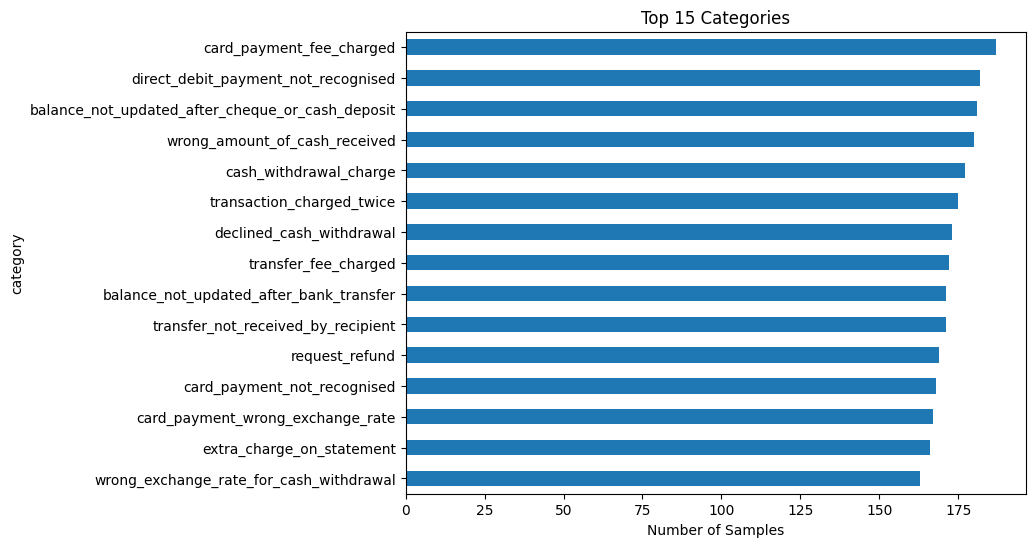

In [ ]:
import matplotlib.pyplot as plt

train_df['category'].value_counts().head(15).plot(kind='barh', figsize=(8, 6), title='Top 15 Categories')
plt.gca().invert_yaxis()
plt.xlabel("Number of Samples")
plt.show()


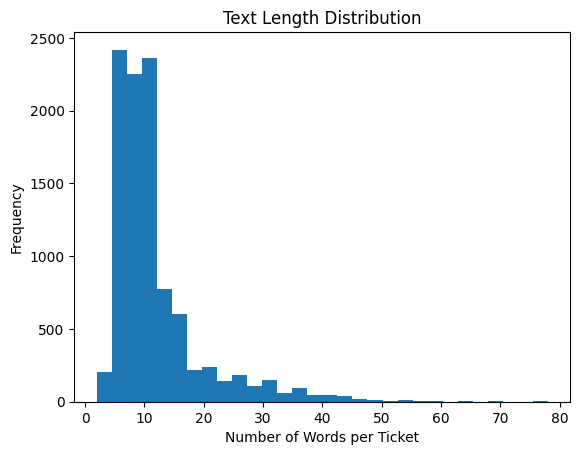

In [ ]:
train_df['text_len'] = train_df['clean_text'].apply(lambda x: len(x.split()))

train_df['text_len'].plot(kind='hist', bins=30, title='Text Length Distribution')
plt.xlabel("Number of Words per Ticket")
plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)  # You can increase features later

X_train = tfidf.fit_transform(train_df['clean_text'])
X_test = tfidf.transform(test_df['clean_text'])

y_train = train_df['label_encoded']
y_test = test_df['label_encoded']


In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)  # More iterations for large data
clf.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))


print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))




Accuracy: 0.8753246753246753

Classification Report:
                                                   precision    recall  f1-score   support

                           Refund_not_showing_up       0.80      0.88      0.83        40
                                activate_my_card       1.00      0.95      0.97        40
                                       age_limit       0.95      1.00      0.98        40
                         apple_pay_or_google_pay       0.98      1.00      0.99        40
                                     atm_support       0.97      0.90      0.94        40
                                automatic_top_up       1.00      0.88      0.93        40
         balance_not_updated_after_bank_transfer       0.63      0.78      0.70        40
balance_not_updated_after_cheque_or_cash_deposit       0.84      0.95      0.89        40
                         beneficiary_not_allowed       0.94      0.82      0.88        40
                                 cancel_trans

In [ ]:
#bert
from transformers import BertForSequenceClassification

num_labels = len(le.classes_)  # 77 for Banking77

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(texts):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=64,
        return_tensors='pt'
    )


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
train_encodings = tokenize_function(train_df['clean_text'].tolist())
test_encodings = tokenize_function(test_df['clean_text'].tolist())


In [ ]:
import torch

class BankingDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [ ]:
train_dataset = BankingDataset(train_encodings, train_df['label_encoded'].tolist())
test_dataset = BankingDataset(test_encodings, test_df['label_encoded'].tolist())


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


In [ ]:
from torch.optim import AdamW
from transformers import get_scheduler

# ✅ Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# ✅ Scheduler
num_epochs = 3
num_training_steps = num_epochs * len(train_loader)

lr_scheduler = get_scheduler(
    name="linear",                     # learning rate schedule
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
..

In [ ]:
train_encodings = tokenizer(train_df['clean_text'].tolist(), truncation=True, padding=True, max_length=64)
test_encodings = tokenizer(test_df['clean_text'].tolist(), truncation=True, padding=True, max_length=64)


In [ ]:
import torch

class BankingDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [ ]:
train_dataset = BankingDataset(train_encodings, train_df['label_encoded'].tolist())
test_dataset = BankingDataset(test_encodings, test_df['label_encoded'].tolist())

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
from tqdm import tqdm

model.train()

for epoch in range(3):
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())


Epoch 3: 100%|██████████| 626/626 [02:00<00:00,  5.20it/s, loss=0.169]


In [ ]:
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())


In [ ]:
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=le.classes_))


Accuracy: 0.9295454545454546

Classification Report:

                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       1.00      1.00      1.00        40
                                activate_my_card       0.97      0.97      0.97        40
                                       age_limit       1.00      1.00      1.00        40
                         apple_pay_or_google_pay       1.00      1.00      1.00        40
                                     atm_support       1.00      0.97      0.99        40
                                automatic_top_up       1.00      0.95      0.97        40
         balance_not_updated_after_bank_transfer       0.71      0.72      0.72        40
balance_not_updated_after_cheque_or_cash_deposit       0.97      0.95      0.96        40
                         beneficiary_not_allowed       0.95      0.93      0.94        40
                                 cancel_trans

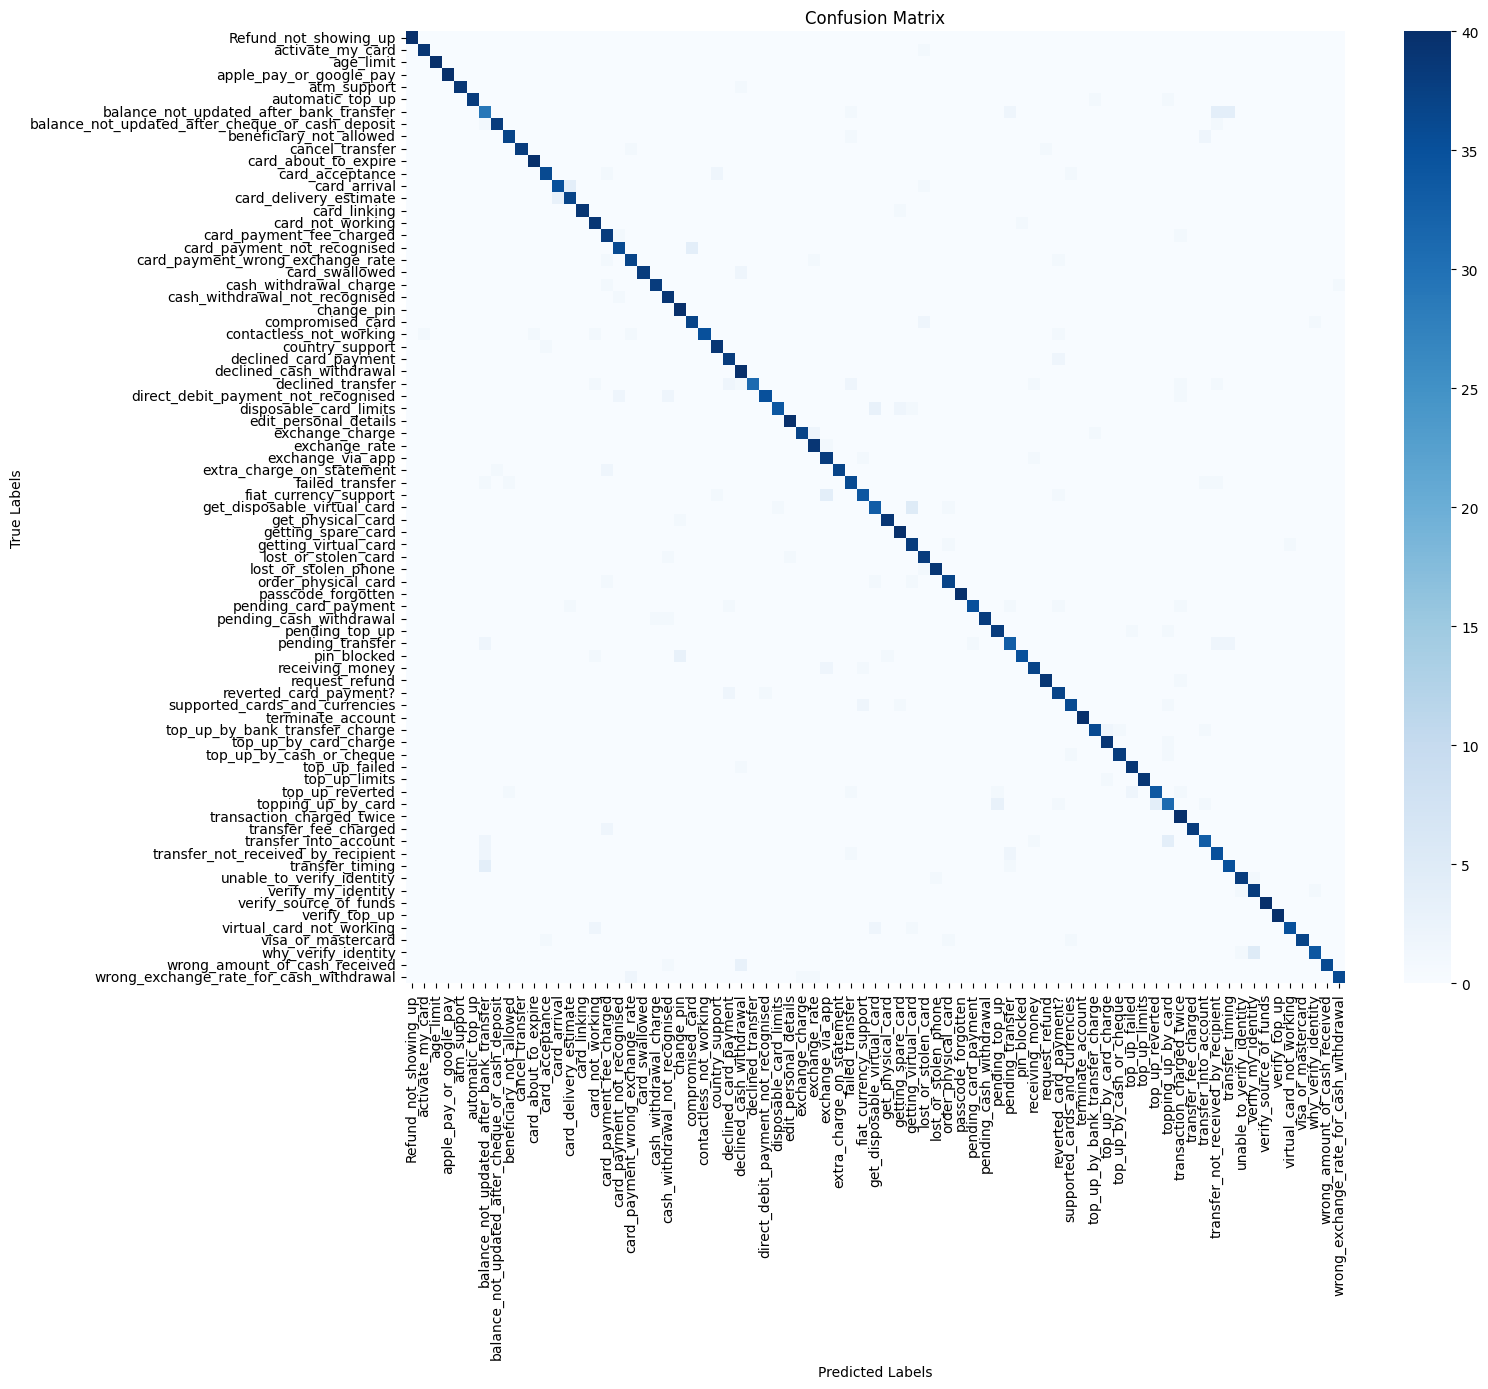

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(16, 14))
sns.heatmap(cm, cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_, cbar=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


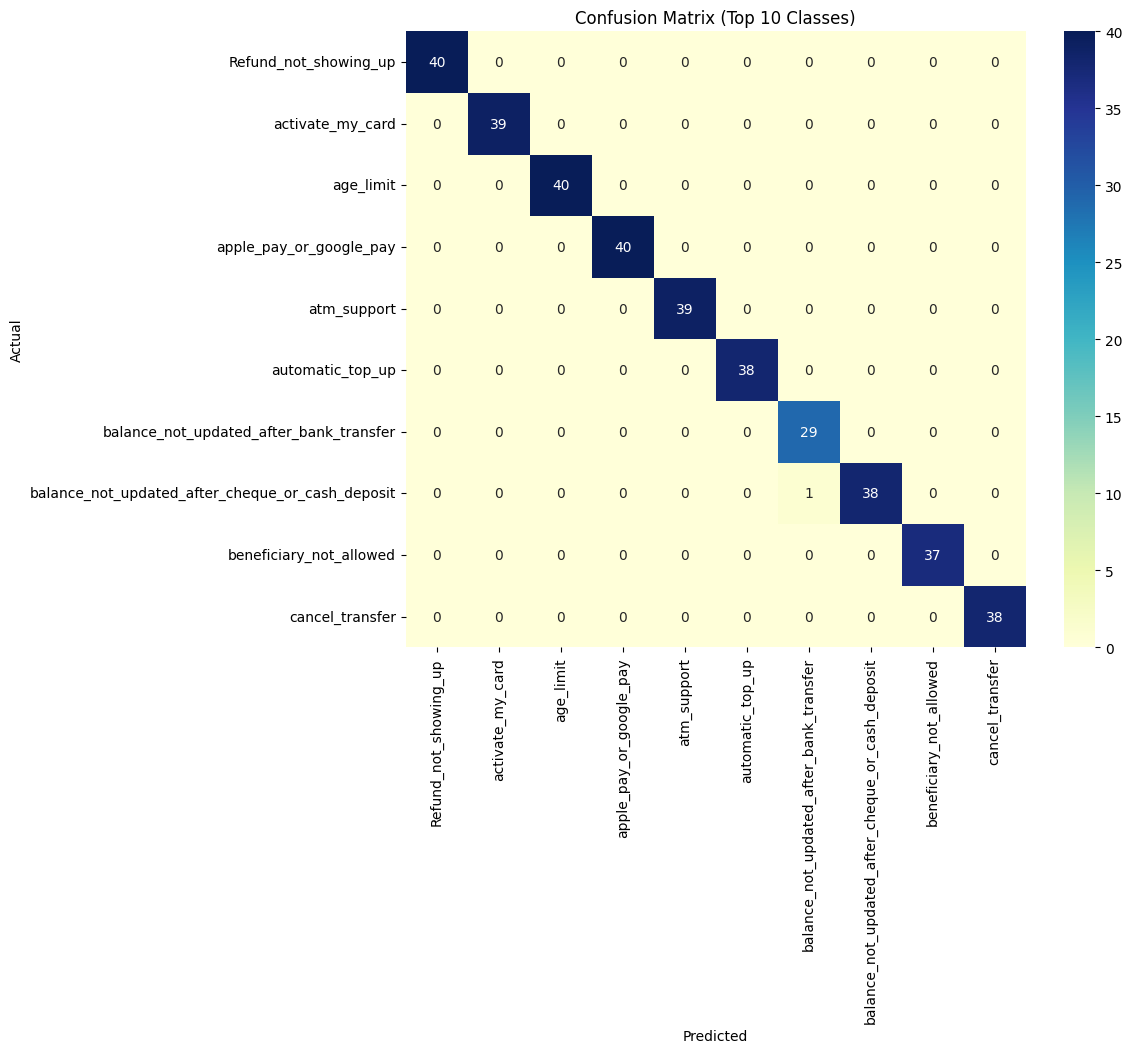

In [ ]:
top_10 = le.classes_[:10]
cm_small = cm[:10, :10]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_small, annot=True, fmt="d", cmap="YlGnBu", xticklabels=top_10, yticklabels=top_10)
plt.title("Confusion Matrix (Top 10 Classes)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


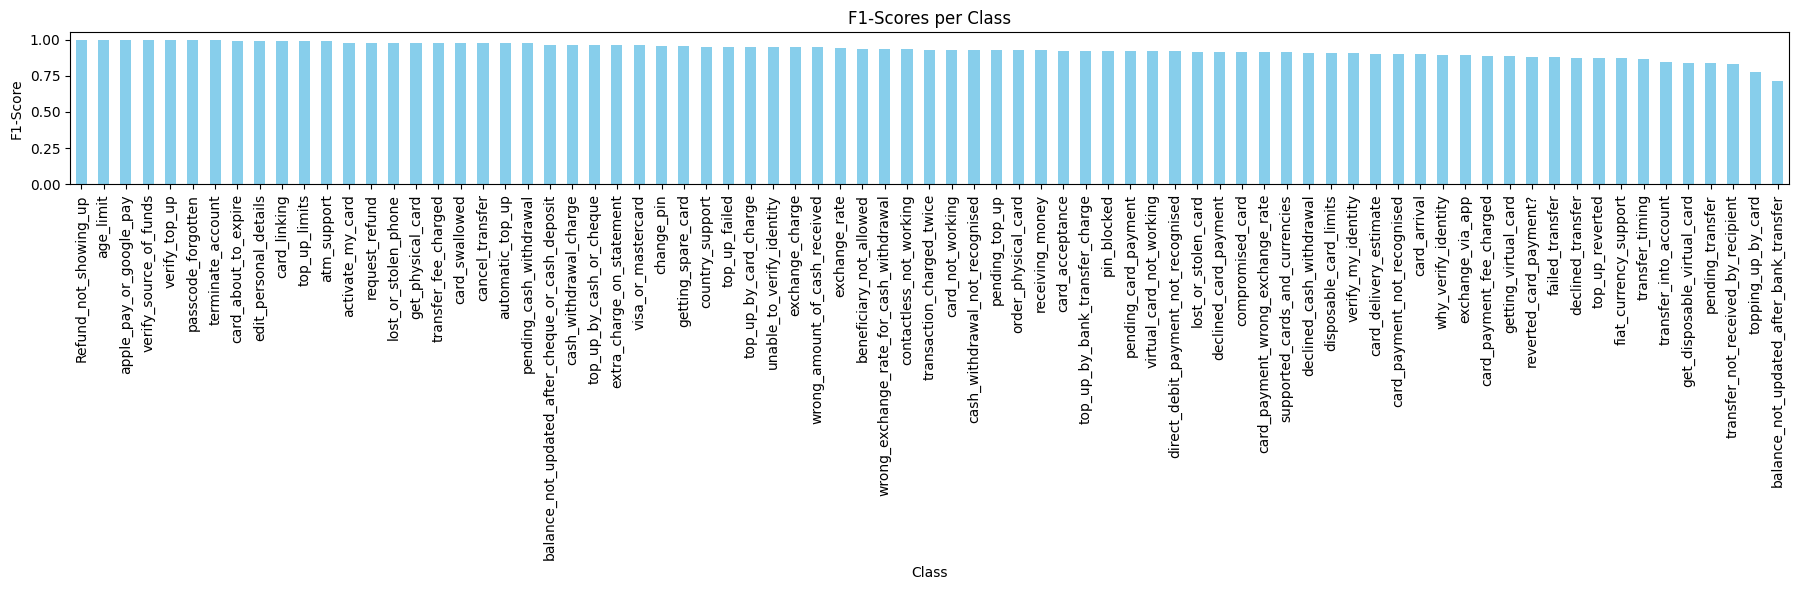

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# Get report as dict
report = classification_report(all_labels, all_preds, target_names=le.classes_, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Plot F1-scores
df_report[:-3].sort_values("f1-score", ascending=False)["f1-score"].plot(kind='bar', figsize=(18, 6), color='skyblue')
plt.title("F1-Scores per Class")
plt.ylabel("F1-Score")
plt.xlabel("Class")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
model.save_pretrained("saved_bert_model")
tokenizer.save_pretrained("saved_bert_model")


('saved_bert_model/tokenizer_config.json',
 'saved_bert_model/special_tokens_map.json',
 'saved_bert_model/vocab.txt',
 'saved_bert_model/added_tokens.json')

In [ ]:
from google.colab import files
import shutil

# Zip the folder
shutil.make_archive('bert_model', 'zip', 'saved_bert_model')

# Download
files.download('bert_model.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>